### RPN是如何产生2万个anchor box的？

一步一步的来解释坐标的形成，以及利用matplotlib可视化anchor box








In [100]:
import numpy as np

以下函数是产生faster RCNN定义的9个anchor的四个坐标，注意这里的坐标是左下右上，数组方式呈现

[y_min, x_min, y_max, x_max]

In [101]:
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2],
                         anchor_scales=[8, 16, 32]):
    
    #py, px可以当做anchor box的中心点坐标
    py = base_size / 2.
    px = base_size / 2.


    #产生shape(9, 4)元素都是0的array
    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4),
                           dtype=np.float32)
    #遍历一遍3x3
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            #利用缩放以及比例的关系，计算出h, w, 正常h会是约90, w则是180左右
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            #计算出左下右上的anchor box 坐标点 [y_min, x_min, y_max, x_max]
            anchor_base[index, 0] = py - h / 2.
            anchor_base[index, 1] = px - w / 2.
            anchor_base[index, 2] = py + h / 2.
            anchor_base[index, 3] = px + w / 2.
    return anchor_base

每16像素就要放置一个anchor中心点遍布整个图像，并且每个点以anchor_base的方式扩撒整张图，生成最终两万多anchor box遍布整个图


In [102]:
def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):

    
    import numpy as xp
    import matplotlib.pyplot as plt
    import matplotlib.pylab as plb
    
    #以图像的长宽 以及 16像素步长 的基础下，制作出网格点，每个点的坐标都是右shift_y以及shift_x来定义
    shift_y = xp.arange(0, height * feat_stride, feat_stride) #shift_y = [0~592, stride=16]
    shift_x = xp.arange(0, width * feat_stride, feat_stride) #shift_x = [0~992, stride=16]
    shift_x, shift_y = xp.meshgrid(shift_x, shift_y)
    #meshgrid可生成网格坐标矩阵，记住 meshgird中 两个array的第一维必须是一样, 此案例shape = (1, 38) and (1, 63)都是1
    #meshgird之后的shift_x, shift_y 都变成了shape(63, 38)的矩阵，meshgrid将x，y变成一一对应的坐标
    
    plb.rcParams['figure.figsize'] = (20.0, 10.0) #将matplotlibd绘制的图形放大，毕竟2000多个红点图太小看不清
    plt.plot(shift_x, shift_y, #将刚生成的(62, 38)， x以及y 一一对其形成坐标，绘制出来
             color="red", 
             marker=".", 
             linestyle='')
    plt.grid(True)
    plt.show()
    
    
    shift = xp.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)
    #将shift_y, shift_x 做stack堆叠变成shape(2394, 4)
    # np.ravel = np.flatten()
    print(shift)
    print(shift.shape)

    A = anchor_base.shape[0] #(9, 4)取9
    print("A:", A)
    K = shift.shape[0]#(2394, 4)取2394
    print("K:", K)
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    anchor = anchor_base.reshape((1, A, 4)) + \
                                shift.reshape((1, K, 4)).transpose((1, 0, 2)) #（2394, 9, 4)
    #这里的transpose 将K和1的位置置换， 变成(1, K, 4) 
    #其实实际reshape成(1, K, 4)也可以                                                  
    print(anchor.shape)
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    #K*A 2394*9 就相当于将2394个中心点按照anchor box的9个点进行扩散到整副图像

    return anchor

In [103]:
def forward(x, feat_stride=16):
    n, _, hh, ww = x.shape
    hh = hh/16
    ww = ww/16
    print(hh, ww)
    anchor = _enumerate_shifted_anchor(
    np.array(anchor_base),
    feat_stride, hh, ww)   
    return anchor #这里返回的是所有的anchor左上右下坐标点

### 以下开始执行

In [104]:
anchor_base = generate_anchor_base()

In [105]:
#模拟一个600*1000的四维image
x = np.ndarray((512, 1, 600, 1000), dtype=np.float64)

In [106]:
print("anchor_base如以下，shape是（9, 4）:\n", anchor_base)

anchor_base如以下，shape是（9, 4）:
 [[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 [ -56.        -56.         72.         72.      ]
 [-120.       -120.        136.        136.      ]
 [-248.       -248.        264.        264.      ]
 [ -82.50967   -37.254833   98.50967    53.254833]
 [-173.01933   -82.50967   189.01933    98.50967 ]
 [-354.03867  -173.01933   370.03867   189.01933 ]]


37.5 62.5


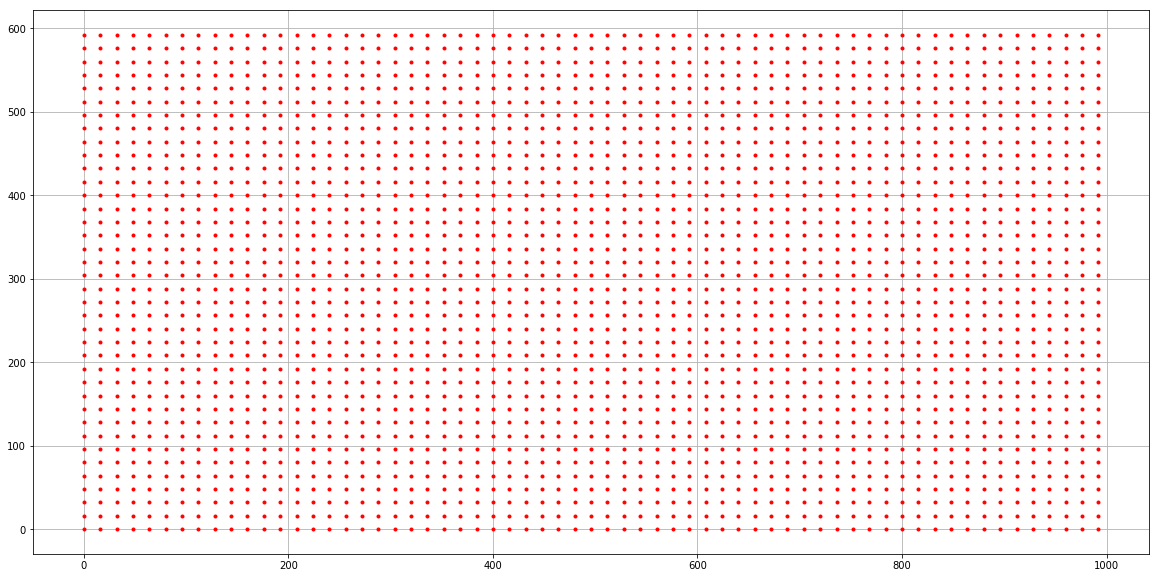

[[  0.   0.   0.   0.]
 [  0.  16.   0.  16.]
 [  0.  32.   0.  32.]
 ...
 [592. 960. 592. 960.]
 [592. 976. 592. 976.]
 [592. 992. 592. 992.]]
(2394, 4)
A: 9
K: 2394
(2394, 9, 4)


In [107]:
anchor = forward(x)

### 上面利用matplotlib绘制的结果清楚看见 每16像素就有一个anchor box中心点

### 一样利用matplotlib 进行anchor_base的绘制

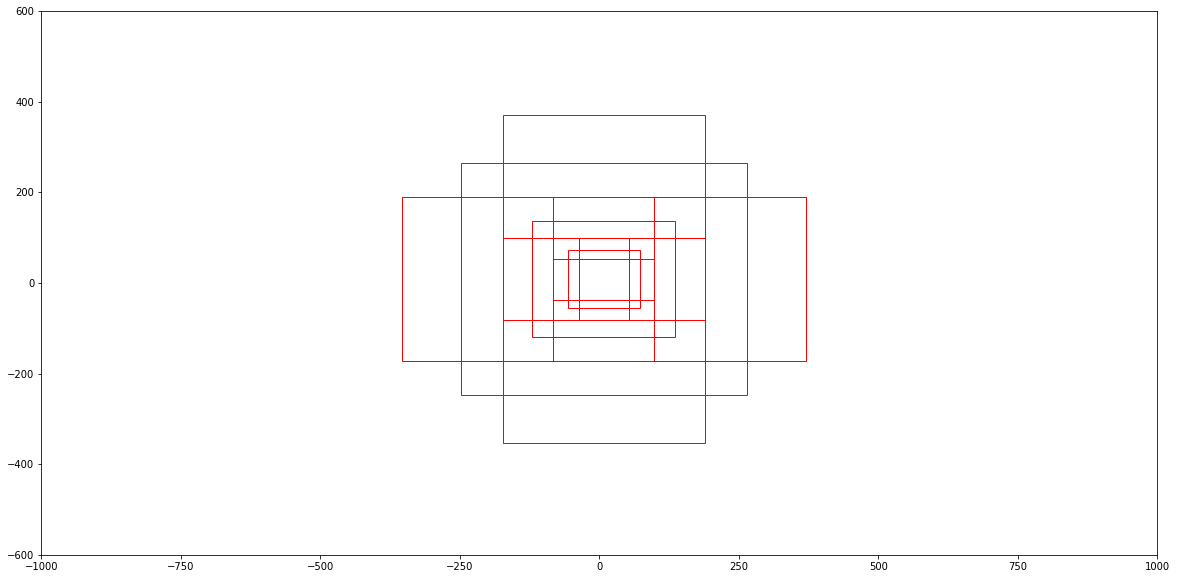

In [108]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle


axes = plt.gca()
axes.set_xlim([-1000,1000])
axes.set_ylim([-600,600])
#anchor_base定义的px, py （8, 8)，anchor的边框一定会到x, y轴的负值， 这边将范围拉大显示

# plt.figure()
axes = plt.gca()

#遍历这9个坐标并且将连成四边形
for i in range(9):
    axes.add_patch(Rectangle((anchor_base[i][1], anchor_base[i][0]), 
                          (anchor_base[i][3] - anchor_base[i][1]),
                          (anchor_base[i][2] - anchor_base[i][0]), fill=None,  alpha=1, color="r"))

plt.show()

### 将20000多个anchor一次遍历生成

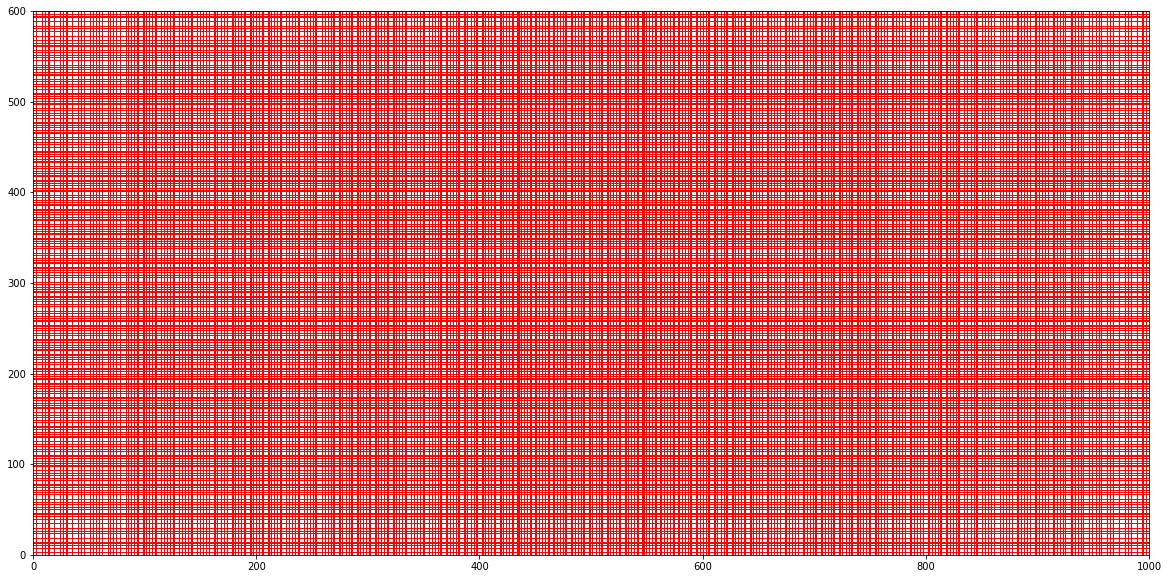

In [109]:
axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([0,600])

# plt.figure()
axes = plt.gca()
for i in range(len(anchor)):
    axes.add_patch(Rectangle((anchor[i][1], anchor[i][0]), 
                          (anchor[i][3] - anchor[i][1]),
                          (anchor[i][2] - anchor[i][0]), fill=None,  alpha=1, color="r"))

plt.show()

### 能看见最终的效果就是anchor box布满在整副图像，这么做就绝对不会漏掉图像中任何一个可能成为target的目标

In [110]:
print(anchor)

[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 ...
 [ 509.49033   954.7452    690.50964  1045.2549  ]
 [ 418.98065   909.49036   781.01935  1090.5096  ]
 [ 237.96133   818.98065   962.0387   1181.0193  ]]


In [111]:
print(anchor.shape)
print(anchor[12304])
print(len(anchor))

(21546, 4)
[253.49033 530.98065 434.50967 893.01935]
21546
